In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
import time

# from model import Model
from dataset import WheatAwnDataset


import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

### Test out the ability to use ResNet50 as opposed to Vgg16

In [13]:
model = models.resnet50(pretrained=True)
#model = models.vgg16(pretrained=True)

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
#find the input features to the last layer
input_features = model.fc.in_features
print("input_features: ",input_features)

input_features:  2048


In [19]:
#make a new last layer
terminal_layer = nn.Linear(input_features, 2)

#replace the original final linear layer with ours
model.fc = terminal_layer

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7619e-01]

Parameter containing:
tensor([-1.0753e-02,  1.2296e-01,  1.8016e-02, -1.4745e-01, -1.0184e-01,
         1.4736e-02, -2.6944e-03, -9.4832e-02, -7.0655e-02, -1.7460e-01,
        -8.9392e-02, -6.2397e-02,  5.8483e-02,  8.1586e-03, -6.0236e-02,
        -8.8126e-02,  4.0486e-02, -9.0144e-02, -6.8058e-02, -1.3243e-01,
         4.6727e-03, -2.2941e-02, -9.3018e-02,  4.8685e-02, -1.6099e-01,
        -1.1730e-01, -1.8592e-01, -5.0664e-02,  5.8731e-02, -4.4601e-02,
        -1.0900e-01,  1.1684e-02, -6.4666e-02, -1.0929e-01, -1.0403e-01,
         9.2314e-03,  1.1211e-02, -1.1996e-01,  5.7720e-02, -3.6448e-02,
        -1.3682e-01, -9.1506e-02, -9.8696e-02, -1.3878e-02, -5.9053e-04,
        -1.3165e-01, -2.1491e-02, -1.0817e-01, -1.4217e-01, -6.5535e-02,
        -1.3517e-01,  5.4794e-02, -1.3225e-01, -7.9678e-02, -8.1386e-02,
         3.1635e-03, -1.1036e-02,  7.3200e-03,  1.5462e-02, -9.3652e-02,
        -2.3393e-02,  2.1940e-02, -9.7693e-02, -6.2564e-02, -7.5043e-02,
        -1.2641e-01, -7.2580e

Parameter containing:
tensor([[[[ 4.0117e-03,  6.4560e-03,  7.5797e-03],
          [ 6.3191e-03,  8.6818e-03,  1.0155e-02],
          [ 1.0467e-02,  7.4264e-03,  1.0289e-02]],

         [[ 8.9806e-03,  8.8232e-03,  1.2227e-02],
          [ 7.9335e-03,  1.2900e-02,  5.7527e-03],
          [ 7.0791e-03,  1.0065e-02,  4.1151e-03]],

         [[ 6.3044e-03,  5.0667e-03,  5.7373e-03],
          [-2.9706e-04, -2.2638e-03,  7.9506e-05],
          [ 6.0903e-04,  3.4252e-04,  2.0867e-03]],

         ...,

         [[-4.3498e-03,  6.7560e-03,  3.5414e-03],
          [ 4.0447e-03,  1.1341e-02,  1.0289e-02],
          [ 6.2327e-03,  1.8316e-02,  1.1889e-02]],

         [[-4.3072e-04, -5.9304e-04, -2.7477e-03],
          [ 1.7383e-03,  1.1411e-03, -2.5095e-03],
          [-7.0297e-03, -8.4976e-03, -1.1197e-02]],

         [[-6.5198e-03, -9.3173e-03, -6.2551e-03],
          [-3.1477e-04,  1.2694e-03,  5.0760e-03],
          [-1.5420e-03, -1.1563e-03,  1.1397e-03]]],


        [[[-8.9216e-03, -5.1781

In [35]:
m = Model('resnet50').construct_model(verbose=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
for param in m.fc.parameters():
#     print(param)
    if param.requires_grad == True:
        print(param)

Parameter containing:
tensor([[-0.0092,  0.0153, -0.0375,  ..., -0.0105,  0.0011, -0.0265],
        [ 0.0104, -0.0266,  0.0005,  ...,  0.0288, -0.0210, -0.0067],
        [-0.0072,  0.0664, -0.0393,  ...,  0.0130, -0.0249, -0.0015],
        ...,
        [-0.0104, -0.0018, -0.0348,  ..., -0.0170,  0.1071,  0.0277],
        [-0.0168, -0.0059, -0.0287,  ..., -0.0214, -0.0048, -0.0133],
        [-0.0215,  0.0239,  0.0809,  ...,  0.0010, -0.0440,  0.0180]],
       requires_grad=True)
Parameter containing:
tensor([-9.0540e-03, -4.1489e-03, -2.0516e-02, -1.7642e-02,  9.6078e-03,
         5.8760e-03, -1.4448e-02,  7.1637e-04,  1.4057e-03, -1.6386e-03,
        -1.2073e-02, -9.3700e-03, -1.9250e-02, -1.7166e-02, -1.1226e-02,
        -1.6972e-02, -8.1289e-03, -1.3626e-02,  8.5068e-03, -1.7855e-02,
         6.9540e-03,  1.8412e-02, -2.4812e-03,  2.4328e-03, -1.3534e-03,
         4.8874e-03,  1.0521e-02, -8.0455e-04, -6.4342e-03, -1.1446e-02,
        -1.3326e-02, -9.2675e-03, -2.5020e-03, -4.5003e-0

In [34]:
class Model():
    """class to hold model objects"""
    def __init__(self, model_name=None):
        """
        Keyword Argumens: 
            model_name : str, optional (default is None)
                options are currently 'vgg16' and 'resnet50' 
        """
            
        self.model_name = model_name

        if model_name == 'vgg16':
            #collect the VGG16 model architecture and weights (trained on
            #the 14million-strong ImageNet dataset) from Pytorch's Model Zoo
            #source: https://pytorch.org/vision/stable/models.html
            #paper: https://arxiv.org/abs/1409.1556
            self.model = models.vgg16(pretrained=True)
            
        elif model_name == 'resnet50':
            #collect the ResNet model architecture (pretrained on ImageNet)
            #source: https://pytorch.org/vision/stable/models.html
            #paper: https://arxiv.org/pdf/1512.03385.pdf
            self.model = models.resnet50(pretrained=True)
            
        else:
            raise Exception("No 'model_name' was specified! (try 'vgg16' or 'resnet50')")

    def construct_model(self, verbose=False):
        """
        function to replace the last fully connected
        layer of the model (1000 nodes for the
        1000 classes of ImageNet) with the custom layer
        we need to solve our problem

        Note: no activation function on the final linear
        layer since we will be using nn.CrossEntropyLoss() 
        as our loss function an that depends upon the raw
        score of the nodes being output at the end of the 
        forward pass

        Keyword Argumens: 
            verbose : bool, optional (default is False)
                control the amount of output when building
                i.e. weather to print the model
        """
        
        if self.model_name == 'vgg16':
            
            #go through the feature extraction portion of the
            #model and ensure that they will not experience weight
            #updates during training
            for param in self.model.features.parameters():
                param.requires_grad = False

            #collect the number of nodes to connect to in the
            #second to last linear layer (vgg16 it's layer 6)
            input_features = self.model.classifier[-1].in_features

            #construct our custom classification layer
            terminal_layer = nn.Linear(input_features, 2)

            #replace the original final linear layer with ours
            self.model.classifier[-1] = terminal_layer

            #check for verbosity
            if verbose: print(self.model)
                
        elif self.model_name == 'resnet50':
            
            #set all params involved in feature extraction to not have 
            #grads updated
            for param in self.model.parameters():
                param.requires_grad = False
            
            #get old last layer's in-features
            input_features = model.fc.in_features
            
            #make a new last layer
            terminal_layer = nn.Linear(input_features, 2)

            #replace the original final linear layer with ours
            model.fc = terminal_layer
            
            #this should not be needed?? Not sure what is going on ¯\_(ツ)_/¯
            for param in self.model.fc.parameters():
                param.requires_grad = True
            
            #check for verbosity
            if verbose: print(self.model)

        return self.model


### let's define the training procedure:
-expose the model to the data first to see what raw inits look like<br/>-then train/validate across epochs<br/>-save every so often<br/>-plot training progress (loss and accuracy)

In [84]:
def expose(model, epoch, dataloader, device, criterion, optimizer):
    print(f"EXPOSE      epoch: {epoch}")
    
    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    #set model mode
    model.eval()

    #make sure to not accumulate gradients
    with torch.no_grad():

        #create progress bar with tqdm
        progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='EXPOSURE Progress: ')

        for step, data in enumerate(progress_bar):

            #unpack the data from the progress bar
            images, labels = data[0], data[1]

            #send the tensors to the device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            #images = images.float() #uncomment if using read_image() from torch
            outputs = model(images) #float?

            #calculate the loss
            loss = criterion(outputs, labels)

            #add to the loss accumulated over the epoch
            epoch_loss += loss.item()

            #find the predicted classes indicies
            _, preds = torch.max(outputs, 1)

            #track the correct predictions (.item()to collect just the value)
            corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100

    #format the epoch loss/accuracy to look nice
    epoch_loss_str = "{:7.5f}".format(epoch_loss)
    accuracy_str = "{:5.2f}".format(accuracy)

    print(f"      ---> loss: {epoch_loss_str} accuracy: {accuracy_str}")

    return epoch_loss, accuracy





def train(model, epoch, dataloader, device, criterion, optimizer, scheduler):
    print(f"[train]     epoch: {epoch}")

    #set model mode
    model.train()

    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    #create progress bar with tqdm
    progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[training] Progress: ')

    for step, data in enumerate(progress_bar):

        #unpack the data from the progress bar
        images, labels = data[0], data[1]

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        #images = images.float() #uncomment if using read_image() from torch
        outputs = model(images)

        #calculate the loss
        loss = criterion(outputs, labels)

        #reset our gradients
        optimizer.zero_grad()

        #propagate backward
        loss.backward()

        #update weights
        optimizer.step()

        #add to the loss accumulated over the epoch
        epoch_loss += loss.item()

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()

    #step learning rate
    print("LEARNING RATE before: ",optimizer.param_groups[0]["lr"])
    scheduler.step()
    print("LEARNING RATE after: ",optimizer.param_groups[0]["lr"])
    
    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100

    #format the epoch loss/accuracy to look nice
    epoch_loss_str = "{:7.5f}".format(epoch_loss)
    accuracy_str = "{:5.2f}".format(accuracy)

    print(f"      ---> loss: {epoch_loss_str} accuracy: {accuracy_str}")

    return epoch_loss, accuracy

def validate(model, epoch, dataloader, device, criterion, optimizer):
    print(f"[validate]  epoch: {epoch}")

    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    #set model mode
    model.eval()

    #make sure to not accumulate gradients
    with torch.no_grad():

        #create progress bar with tqdm
        progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[validation] Progress: ')

        for step, data in enumerate(progress_bar):

            #unpack the data from the progress bar
            images, labels = data[0], data[1]

            #send the tensors to the device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            #images = images.float() #uncomment if using read_image() from torch
            outputs = model(images)

            #calculate the loss
            loss = criterion(outputs, labels)

            #add to the loss accumulated over the epoch
            epoch_loss += loss.item()

            #find the predicted classes indicies
            _, preds = torch.max(outputs, 1)

            #track the correct predictions
            corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100
    
    #format the epoch loss/accuracy to look nice
    epoch_loss_str = "{:7.5f}".format(epoch_loss)
    accuracy_str = "{:5.2f}".format(accuracy)

    print(f"      ---> loss: {epoch_loss_str} accuracy: {accuracy_str}")

    return epoch_loss, accuracy

In [85]:
def main():

    print('running...\n\n')
    current_time = time.strftime("%Y-%m-%d-%H_%M_%S")

    #set the 'device' customary var for the GPU (or CPU if not available)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print("(using device: ", device,")\n\n")


    #construct the datasets
    dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
    dir_path = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/'

    #training data
    print("building training set...")
    train_data_csv = os.path.join(dir_path,'data/2019_train_awns_tiny.csv')
    print(train_data_csv)
    train_transform = transforms.Compose([transforms.RandomCrop((224,224)),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor()])
    
    training_data = WheatAwnDataset(csv_filepath=train_data_csv,
                                    dataset_dir=dataset_path,
                                    transform=train_transform)

    train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

    #validation data
    print("building validation set...")
    validation_data_csv = os.path.join(dir_path,'data/2019_val_awns_tiny.csv')
    validation_transform = transforms.Compose([transforms.ToTensor()])
    
    validation_data = WheatAwnDataset(csv_filepath=validation_data_csv,
                                      dataset_dir=dataset_path,
                                      transform=validation_transform)

    validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)

    #build the model
    model = Model().construct_model(verbose=False)

    model = model.to(device)

    #loss function
    criterion = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
    
    #set up scheduler
    lmbda = lambda epoch: 0.55 ** epoch
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

    #set up lists to track training progress
    training_loss_history, training_accuracy_history = [], []
    validation_loss_history, validation_accuracy_history = [], []

    exposure_training_loss_history, exposure_training_accuracy_history = [], []
    exposure_validation_loss_history, exposure_validation_accuracy_history = [], []

    #train the model across epochs
    epochs = 10
    print(f"\n\ntraining across {epochs} epochs\n\n")

    for epoch in range(epochs):

        #make sure to expose the model first, with just the raw initilizations
        if epoch == 0:
            loss, accuracy = expose(model, epoch-1, train_dataloader, device, criterion, optimizer)
            exposure_training_loss_history.append(loss)
            exposure_training_accuracy_history.append(accuracy)

            loss, accuracy = expose(model, epoch-1, validation_dataloader, device, criterion, optimizer)
            exposure_validation_loss_history.append(loss)
            exposure_validation_accuracy_history.append(accuracy)

        #train
        loss, accuracy = train(model, epoch, train_dataloader, device, criterion, optimizer, scheduler)
        training_loss_history.append(loss)
        training_accuracy_history.append(accuracy)

        #validate
        val_loss, val_accuracy = validate(model, epoch, validation_dataloader, device, criterion, optimizer)
        validation_loss_history.append(val_loss)
        validation_accuracy_history.append(val_accuracy)

        #save a dictionary of the current training loss/accuracy history as a pickel
        history_dict = {'date': current_time,
                        'epochs': epoch+1,
                        'training_loss_history':training_loss_history,
                        'training_accuracy_history':training_accuracy_history,
                        'validation_loss_history':validation_loss_history,
                        'validation_accuracy_history':validation_accuracy_history,
                        'exposure_training_loss_history': exposure_training_loss_history,
                        'exposure_training_accuracy_history': exposure_training_accuracy_history,
                        'exposure_validation_loss_history': exposure_validation_loss_history,
                        'exposure_validation_accuracy_history': exposure_validation_accuracy_history}
        
        #overwrite the previous file with the name, also note: using 'wb' so use 'rb' to load
        with open(os.path.join(dir_path, f"runs/{current_time}_training_history.pkl"), 'wb') as f:
            pickle.dump(history_dict, f)
#/////////////////////                   
#         if epoch%1 == 0 and epoch != 0 and epoch != epochs:
#             #save the model (parameters only) every so often
#             print(f"\n\nsaving model at epoch {epoch} path:\n     ../runs/{current_time}_model_epoch-{epoch}.pth")
#             torch.save(model.state_dict(), os.path.join(dir_path, f"runs/{current_time}_model_epoch-{epoch+1}_val-acc-{val_accuracy:.3f}.pth"))
   
    #save final model and plot training history
#     torch.save(model.state_dict(), os.path.join(dir_path, f"runs/{current_time}_model_epoch-{epoch+1}_val-acc-{val_accuracy:.3f}.pth"))
    
#     print("\nfinal state_dict saved... plotting accuracy/loss history")

    fig = plt.figure(figsize=(20,8))

    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Training/Validation Loss across Epochs")
    plt.scatter([-0.1], exposure_training_loss_history, c='darkblue', marker="P", label='EXP-train-loss')
    plt.scatter([-0.1], exposure_validation_loss_history, c='orangered', marker="X", label= 'EXP-val-loss')
    plt.plot(range(epochs), training_loss_history, label='train-loss')
    plt.plot(range(epochs), validation_loss_history, label= 'validation-loss')
    
    plt.ylabel('Training/Validation Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("Training/Validation Accuracy across Epochs")
    plt.scatter([-0.1], exposure_training_accuracy_history,c='darkblue', marker="P", label='EXP-train-accuracy')
    plt.scatter([-0.1], exposure_validation_accuracy_history, c='orangered', marker="X", label= 'EXP-val-accuracy')
    plt.plot(range(epochs), training_accuracy_history, label='train-accuracy')
    plt.plot(range(epochs), validation_accuracy_history, label= 'validation-accuracy')
    plt.ylabel('Training/Validation accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    
    fig.suptitle(f"Training Run Loss/Accuracy History {current_time}")
    fig.savefig(os.path.join(dir_path, f"runs/{current_time}_loss_accuracy-plot.jpg"))

    print("\n...terminating")
    
    print(history_dict)

#### ..now actually run the training loop

running...


(using device:  cuda:0 )


building training set...
/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_tiny.csv
data file "2019_train_awns_tiny.csv" contains 200 rows
building validation set...
data file "2019_val_awns_tiny.csv" contains 40 rows


training across 10 epochs


EXPOSE      epoch: -1


EXPOSURE Progress: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


      ---> loss: 0.74434 accuracy: 35.50
EXPOSE      epoch: -1


EXPOSURE Progress: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


      ---> loss: 0.70530 accuracy: 35.00
[train]     epoch: 0


[training] Progress: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


LEARNING RATE before:  1e-05
LEARNING RATE after:  5.500000000000001e-06
      ---> loss: 0.71068 accuracy: 53.50
[validate]  epoch: 0


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


      ---> loss: 0.60776 accuracy: 85.00
[train]     epoch: 1


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


LEARNING RATE before:  5.500000000000001e-06
LEARNING RATE after:  1.6637500000000004e-06
      ---> loss: 0.58163 accuracy: 75.50
[validate]  epoch: 1


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


      ---> loss: 0.56138 accuracy: 92.50
[train]     epoch: 2


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


LEARNING RATE before:  1.6637500000000004e-06
LEARNING RATE after:  2.768064062500001e-07
      ---> loss: 0.54053 accuracy: 84.00
[validate]  epoch: 2


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


      ---> loss: 0.52291 accuracy: 92.50
[train]     epoch: 3


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


LEARNING RATE before:  2.768064062500001e-07
LEARNING RATE after:  2.532951621191408e-08
      ---> loss: 0.55428 accuracy: 79.00
[validate]  epoch: 3


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


      ---> loss: 0.52754 accuracy: 92.50
[train]     epoch: 4


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


LEARNING RATE before:  2.532951621191408e-08
LEARNING RATE after:  1.274794973576555e-09
      ---> loss: 0.56168 accuracy: 79.50
[validate]  epoch: 4


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


      ---> loss: 0.51670 accuracy: 92.50
[train]     epoch: 5


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


LEARNING RATE before:  1.274794973576555e-09
LEARNING RATE after:  3.5287141534129e-11
      ---> loss: 0.55706 accuracy: 78.00
[validate]  epoch: 5


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


      ---> loss: 0.55460 accuracy: 92.50
[train]     epoch: 6


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


LEARNING RATE before:  3.5287141534129e-11
LEARNING RATE after:  5.372238759193552e-13
      ---> loss: 0.54086 accuracy: 78.00
[validate]  epoch: 6


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


      ---> loss: 0.53562 accuracy: 92.50
[train]     epoch: 7


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


LEARNING RATE before:  5.372238759193552e-13
LEARNING RATE after:  4.498387065959215e-15
      ---> loss: 0.54138 accuracy: 83.00
[validate]  epoch: 7


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


      ---> loss: 0.53661 accuracy: 92.50
[train]     epoch: 8


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


LEARNING RATE before:  4.498387065959215e-15
LEARNING RATE after:  2.0716721475396104e-17
      ---> loss: 0.52987 accuracy: 82.00
[validate]  epoch: 8


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


      ---> loss: 0.52456 accuracy: 92.50
[train]     epoch: 9


[training] Progress: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


LEARNING RATE before:  2.0716721475396104e-17
LEARNING RATE after:  5.2474453246875434e-20
      ---> loss: 0.52109 accuracy: 82.00
[validate]  epoch: 9


[validation] Progress: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


      ---> loss: 0.52699 accuracy: 92.50

...terminating
{'date': '2021-10-24-14_46_21', 'epochs': 10, 'training_loss_history': [0.7106765082904271, 0.5816316264016288, 0.5405287487166268, 0.5542753849710736, 0.5616820710045951, 0.5570572870118278, 0.540860367672784, 0.5413797753197807, 0.5298665506499154, 0.5210852069514138], 'training_accuracy_history': [53.5, 75.5, 84.0, 79.0, 79.5, 78.0, 78.0, 83.0, 82.0, 82.0], 'validation_loss_history': [0.6077600419521332, 0.5613796710968018, 0.5229061841964722, 0.5275429487228394, 0.5167030692100525, 0.5546027719974518, 0.5356150269508362, 0.5366126596927643, 0.5245635211467743, 0.5269937813282013], 'validation_accuracy_history': [85.0, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5], 'exposure_training_loss_history': [0.7443357280322483], 'exposure_training_accuracy_history': [35.5], 'exposure_validation_loss_history': [0.7052990794181824], 'exposure_validation_accuracy_history': [35.0]}


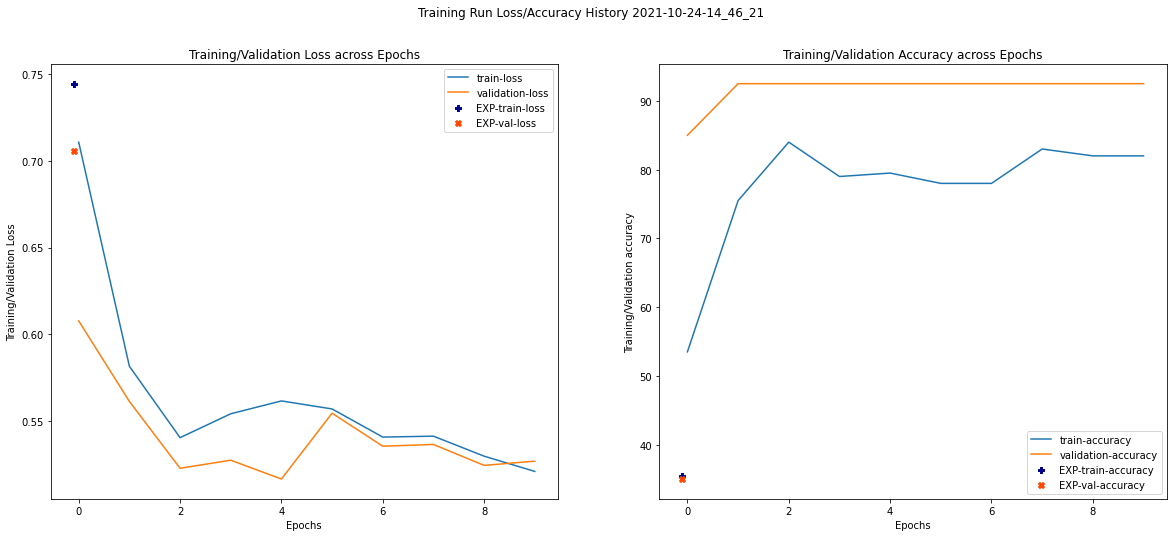

In [86]:
main()

## Load the Saved History Pickel
-now I can maintain a record of training performance outside of the visual display<br/>
-basically this will be a rudimentary tensorboard

In [74]:
#sort files
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files]# add path to each file

files = [file for file in files if file.endswith('.pkl')]
files.sort(key=lambda x: os.path.getmtime(x))

#note since I used 'wb' in the creation I need to use 'rb' when reading
#wb = write binary, rb = read binary
with open(files[-1], 'rb') as f:
    loaded_history = pickle.load(f)

print(loaded_history)

{'date': '2021-10-23-16_30_54', 'epochs': 10, 'training_loss_history': [0.7119251149041312, 0.5734070071152279, 0.445362389087677, 0.40587223853383747, 0.31524218193122316, 0.2576518122638975, 0.20500264848981584, 0.16015956763710296, 0.1405924420271601, 0.11415744519659451], 'training_accuracy_history': [50.5, 75.0, 87.0, 89.0, 93.0, 95.5, 97.5, 98.0, 98.0, 97.0], 'validation_loss_history': [0.6940663456916809, 0.5520539879798889, 0.454606756567955, 0.40761858224868774, 0.41083356738090515, 0.3048279732465744, 0.21662944555282593, 0.23907411098480225, 0.2000436633825302, 0.19757015258073807], 'validation_accuracy_history': [52.5, 90.0, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5], 'exposure_training_loss_history': [0.776680018220629], 'exposure_training_accuracy_history': [50.0], 'exposure_validation_loss_history': [0.7901835739612579], 'exposure_validation_accuracy_history': [50.0]}


In [51]:
so = ' noooot'
os.path.join('/weet/',f'is{so}/a/plant/yuh')

'/weet/is noooot/a/plant/yuh'

## Visualize the Training Progress 
-on fixed axes!<br/>-training and validation progress on the same graph!

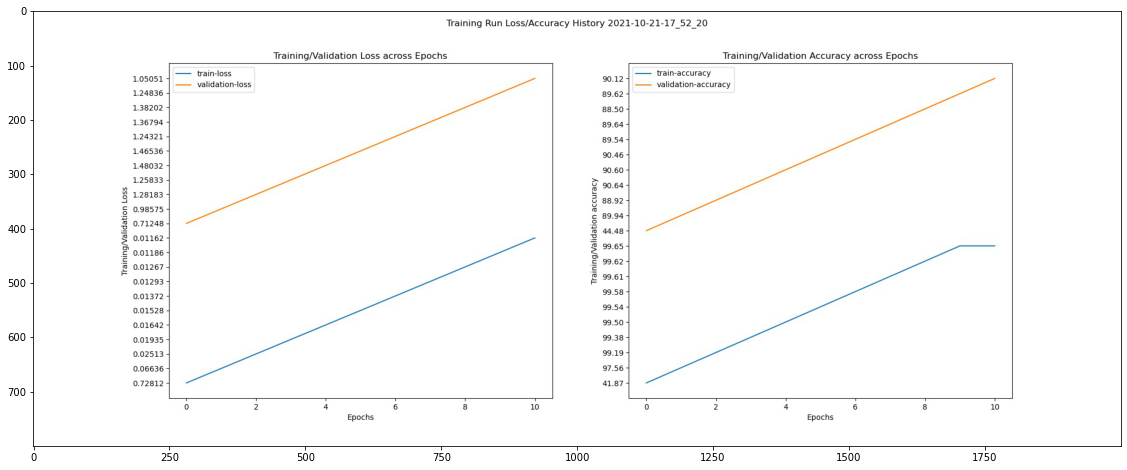

In [13]:
import PIL

#sort files
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files]# add path to each file

files = [file for file in files if file.endswith('.jpg')]
files.sort(key=lambda x: os.path.getmtime(x))

#show the most recent training plot
plot_img = PIL.Image.open(files[-1])
plt.figure(figsize = (20,8))
plt.imshow(plot_img)

### Test the Ability to Load a Trained Model
-get predictions on data<br/>-visualize

In [148]:
#sort files in runs dir
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files]# add path to each file

files = [file for file in files if file.endswith('.pth')] #only get model files
files.sort(key=lambda x: os.path.getmtime(x))

#instantiate the most recent model
print(f"loading model from: {files[-1]}")
saved_model = Model().construct_model(verbose=False)
saved_model.load_state_dict(torch.load(files[-1]))


loading model from: /pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-19-13_16_11_model_epoch-4.pth


<All keys matched successfully>

In [201]:
#collect dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns_tiny.csv'
batch_size = 8

transform = None
data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [202]:
def imshow(img):
    '''helper fn stolen from pytorch.org tutorial :)'''
    npimg = img.numpy()
    plt.figure(figsize = (20,8))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
    plt.show()

In [203]:
#note class label (awned: 0, awnless: 1)
classes = ('awned', 'awnless')

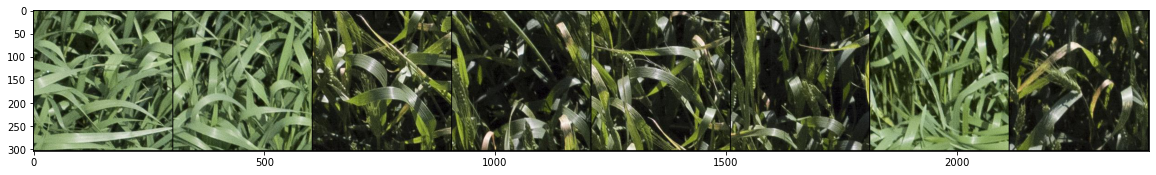

Ground Truth:  awned - awned - awnless - awnless - awnless - awnless - awned - awnless


In [204]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ',' - '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [205]:
images = images.float()
outputs = saved_model(images)

In [206]:
_, preds = torch.max(outputs, 1)
print('Predicted: ', ' - '.join('%5s' % classes[preds[j]] for j in range(batch_size)))

Predicted:  awned - awned - awnless - awnless - awnless - awnless - awned - awnless


In [220]:
#conf matrix from: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
from sklearn.metrics import confusion_matrix

# Get the predictions
predictions = []
ground_truths = []

for images, labels in dataloader:
    images = images.float()
    outputs = saved_model(images)
    _, preds = torch.max(outputs, 1)
    
    ground_truths.extend(list(labels.numpy()))
    predictions.extend(list(preds.numpy()))

print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

predictions:    40
ground truths:  40


In [226]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

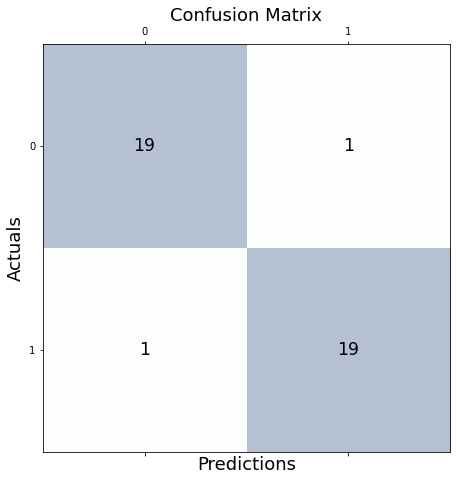

In [227]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### We should also calculate the mean and standard deviation of the dataset to normalize for training
normalization values found for training dataset: (tensor([77.7395, 83.9253, 53.3458]), tensor([48.1450, 49.1999, 36.7069])) -> this is incorrect<br/>

trying a different approach

In [187]:
#calculate the mean and standard deviation of the dataset
#from here: https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    prog_bar = tqdm.tqdm(dataloader, total=int(len(dataloader)), desc='prog: ')
    
    for step, data in enumerate(prog_bar):
        # Mean over batch, height and width, but not over the channels
        data = data[0]
        data = data.float()
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
#this version might be better, but I'm going to put these in a seperate script
def mean_std_for_loader(loader: DataLoader):
    
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0
    
    for data, _ in tqdm(loader):
        this_batch_size = data.size()[0]
        weight = this_batch_size / loader.batch_size
        
        
        channels_sum += weight*torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += weight*torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += weight
        
    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5
    
    return mean, std

In [188]:
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
# data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv'

batch_size = 64

transform = None
data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [189]:
len(dataloader)

7070

In [190]:
get_mean_and_std(dataloader)


prog:   4%|▎         | 265/7070 [06:37<2:23:49,  1.27s/it]


prog:   7%|▋         | 529/7070 [13:08<2:53:16,  1.59s/it]


prog:  11%|█         | 793/7070 [19:44<2:44:58,  1.58s/it]


prog:  15%|█▍        | 1056/7070 [26:25<2:25:44,  1.45s/it]


prog:  19%|█▊        | 1316/7070 [32:54<2:18:27,  1.44s/it]


prog:  22%|██▏       | 1576/7070 [39:17<2:11:21,  1.43s/it]


prog:  26%|██▌       | 1836/7070 [45:51<2:29:07,  1.71s/it]


prog:  30%|██▉       | 2096/7070 [52:22<1:59:30,  1.44s/it]


prog:  33%|███▎      | 2356/7070 [58:46<1:58:54,  1.51s/it]


prog:  37%|███▋      | 2609/7070 [1:05:07<2:04:31,  1.67s/it]


prog:  40%|████      | 2861/7070 [1:11:30<1:43:16,  1.47s/it]


prog:  44%|████▍     | 3113/7070 [1:17:43<1:34:16,  1.43s/it]


prog:  48%|████▊     | 3365/7070 [1:24:04<1:42:45,  1.66s/it]


prog:  51%|█████     | 3617/7070 [1:30:20<1:30:06,  1.57s/it]


prog:  55%|█████▍    | 3869/7070 [1:36:23<1:02:53,  1.18s/it]


prog:  58%|█████▊    | 4121/7070 [1:42:39<1:09:41,  1.42s/it]


prog:  62%|██████▏   | 4373/7070 [1:48:55<1:04:10,  1.43s/it]


prog:  65%|██████▌   | 4625/7070 [1:55:07<1:10:53,  1.74s/it]


prog:  69%|██████▉   | 4882/7070 [2:01:28<1:01:53,  1.70s/it]


prog:  73%|███████▎  | 5141/7070 [2:07:53<47:50,  1.49s/it]


prog:  76%|███████▋  | 5400/7070 [2:14:27<42:23,  1.52s/it]


prog:  80%|████████  | 5660/7070 [2:20:09<35:42,  1.52s/it]


prog:  84%|████████▎ | 5920/7070 [2:25:07<20:28,  1.07s/it]


prog:  87%|████████▋ | 6180/7070 [2:30:02<17:59,  1.21s/it]


prog:  91%|█████████ | 6440/7070 [2:34:53<10:47,  1.03s/it]


prog:  95%|█████████▍| 6700/7070 [2:39:42<07:30,  1.22s/it]


prog:  98%|█████████▊| 6960/7070 [2:44:29<01:59,  1.08s/it]


prog: 100%|██████████| 7070/7070 [2:46:27<00:00,  1.41s/it]


(tensor([77.7395, 83.9253, 53.3458]), tensor([48.1450, 49.1999, 36.7069]))